In [1]:
%matplotlib inline

In [1]:
import numpy as np
import scipy as sp
import scipy.cluster.hierarchy
from scipy.spatial.distance import pdist, squareform

from sklearn import datasets

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
sys.path.append('../../')
from pyprotoclust import protoclust

In [9]:
def axlabel(ax, xlabel, ylabel, zlabel=None, params={}):
    ''' Shorthand for axis labelling '''
    ax.set_xlabel(xlabel, **params)
    ax.set_ylabel(ylabel, **params)
    if zlabel:
        ax.set_zlabel(zlabel, **params)
    return ax

def fancy_dendrogram(ax, *args, **kwargs):
    ''' Nicer plotting of dendrograms courtesy of https://joernhees.de/blog/ '''
    title = ''
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = sp.cluster.hierarchy.dendrogram(*args, **kwargs)

    if kwargs.get('truncate_mode', False):
        title = title + ', p={}'.format(kwargs.get('p', None))
    
    if not kwargs.get('no_plot', False):
        ax.set_title(title)
        ax.set_ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                ax.plot(x, y, 'o', c=c)
        if max_d:
            ax.axhline(y=max_d, c='k', ls='--')
    return ddata

# Example 1: Gaussians in 2D

This example shows how the cut height is related to the within-cluster variance.

In [12]:
mpl.rcParams.update({'font.size': 16})

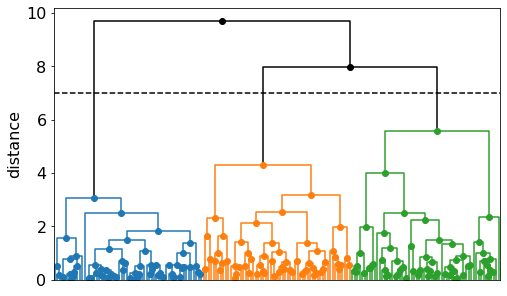

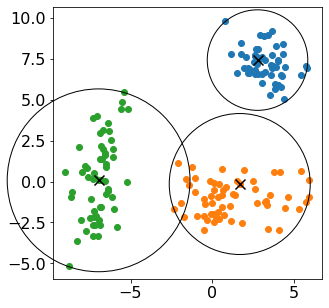

In [13]:
n = 60
np.random.seed(4)

examples = [{'mean': [-7, 0], 'cov': [[1, 1], [1, 5]]},
            {'mean': [1, -1], 'cov': [[5, 0], [0, 1]]},
            {'mean': [3, 7], 'cov': [[1, 0], [0, 1]]}]
data = np.vstack([np.random.multivariate_normal(i['mean'], i['cov'], n) for i in examples])

# Produce clustering
Z, prototypes = protoclust(squareform(pdist(data)), verbose=True, notebook=True)
Z = np.array(Z)
prototypes = np.array(prototypes)

cut_height = 7

# Get clusters associated with the cut height
T = sp.cluster.hierarchy.fcluster(Z, cut_height, criterion='distance')
L,M = sp.cluster.hierarchy.leaders(Z, T)

# Set the default color map
cmap = plt.cm.get_cmap('tab10', 10)
sp.cluster.hierarchy.set_link_color_palette([mpl.colors.to_hex(cmap(k-1)) for k in np.unique(T)])

# Plot dendrogram with a specific cut height
fig,ax = plt.subplots(1, figsize=[8,5])
fancy_dendrogram(ax, Z, max_d=cut_height, above_threshold_color='k')
ax.set_xticks([])

# Plot data
fig,ax = plt.subplots(1, figsize=[5,5])
ax.set_aspect('equal')
for i in range(3):
    ax.scatter(data[i*n:(i+1)*n,0], data[i*n:(i+1)*n,1], color=cmap(T[i*n]-1))

# Plot prototypes with cut heights as circles
centers = data[prototypes[L]]
ax.scatter(*centers.T, c='k', marker='x', s=100)
for xy, r in zip(centers, Z[L-len(data), 2]):
    ax.add_artist(mpl.patches.Circle(xy, radius=r, fill=False, clip_on=False))

# Example 2: Olivetti faces dataset

This example shows how the method naturally lends itself to datasets where image representatives of clusters are desirable.

In [ ]:
# Load faces
faces = datasets.fetch_olivetti_faces()
X = faces.data
n,d = X.shape # d = 64x64 = 4096
Y = faces.target

# Compute SVD
U,S,Vt = np.linalg.svd(X - np.mean(X, axis=0))

# Plot SVD basis 
fig, ax = plt.subplots(1, 3, figsize=[9,3])
fig.subplots_adjust(wspace=0.1)

for i in range(3):
    ax[i].imshow(Vt[:,i].reshape(64,64), cmap='gray')
    ax[i].axis("off")
    ax[i].set_title('Component {}'.format(i))

# Plot SVD spectrum
fig, ax = plt.subplots(1, figsize=[5,3])
ax.set_title('Olivetti faces SVD spectrum')
ax.scatter(list(range(len(S))), S, marker='+', c='k')

In [ ]:
# Plot projected coordinates and color by label
fig= plt.figure(figsize=[9,7])
ax = fig.add_subplot(111, projection='3d')
pcX = X@Vt.T[:,:3]
cmap = plt.cm.get_cmap('gnuplot', len(np.unique(Y)))
for i,j,k,c in zip(pcX[:,0], pcX[:,1], pcX[:,2], Y):
    ax.scatter(i,j,k,color=cmap(c))
axlabel(ax, 'A','B','C', {'fontsize': 12});

In [ ]:
# Cluster
Z, prototypes = protoclust(squareform(pdist(pcX)), verbose=True, notebook=True)
prototypes = np.array(prototypes)

cut_height = 6

T = sp.cluster.hierarchy.fcluster(Z, cut_height, criterion='distance')
indices,_ = sp.cluster.hierarchy.leaders(Z,T)

# Discretize color map based on cluster number
cmap = plt.cm.get_cmap('nipy_spectral', len(np.unique(T))+1)
sp.cluster.hierarchy.set_link_color_palette([mpl.colors.to_hex(cmap(k)) for k in np.unique(T)])

# Plot 1: dendrogram
fig,ax  = plt.subplots(1, figsize=[9,6])
fancy_dendrogram(ax, Z, max_d=cut_height, above_threshold_color='k')
ax.set_xticks([]);

In [ ]:
# Plot 2: Projected clusters
fig= plt.figure(figsize=[10,8])
ax = fig.add_subplot(111, projection='3d')

# Project onto the principle components from the SVD
pcX = X@Vt.T[:,:3]

# Plot faces in this reduced space
for index, row in enumerate(pcX):
    ax.scatter(*row, color=cmap(T[index]), alpha=0.5)

for p in prototypes[indices]:
    ax.scatter(*pcX[p, :], edgecolor='k', facecolor=cmap(T[p]), s=800, marker='o')
             
axlabel(ax, 'A','B','C', {'fontsize': 14});

In [ ]:
# Plot 3: Prototypes
fig, axes = plt.subplots(2,len(indices)//2+1, figsize=[12,4])
fig.subplots_adjust(wspace=.1, hspace=0)
for i,iax in enumerate(axes.flatten()):
    if i < len(indices):
        p = prototypes[indices[i]]
        c = cmap(T[p])
        iax.set_xticks([])
        iax.set_yticks([])
        iax.set_facecolor(c)
        im = X[p].reshape(64,64)
    else:
        im = np.ones([64,64])
        iax.axis('off')
    iax.imshow(im, alpha=0.6, cmap='gray', vmin=0, vmax=1)